Loading datasets...
Datasets loaded successfully.
Initializing model...
Starting training...
Using device: cpu
Epoch [1/40] - Loss: 0.211681 | AvgCosSim vs PCA: 0.0065
Epoch [2/40] - Loss: 0.125186 | AvgCosSim vs PCA: 0.0069
Epoch [3/40] - Loss: 0.107473 | AvgCosSim vs PCA: 0.0061
Epoch [4/40] - Loss: 0.099553 | AvgCosSim vs PCA: 0.0051
Epoch [5/40] - Loss: 0.095087 | AvgCosSim vs PCA: 0.0038
Epoch [6/40] - Loss: 0.092127 | AvgCosSim vs PCA: 0.0025
Epoch [7/40] - Loss: 0.090048 | AvgCosSim vs PCA: 0.0016
Epoch [8/40] - Loss: 0.088379 | AvgCosSim vs PCA: 0.0005
Epoch [9/40] - Loss: 0.087094 | AvgCosSim vs PCA: -0.0004
Epoch [10/40] - Loss: 0.086040 | AvgCosSim vs PCA: -0.0013
Epoch [11/40] - Loss: 0.085234 | AvgCosSim vs PCA: -0.0018
Epoch [12/40] - Loss: 0.084523 | AvgCosSim vs PCA: -0.0023
Epoch [13/40] - Loss: 0.083897 | AvgCosSim vs PCA: -0.0026
Epoch [14/40] - Loss: 0.083406 | AvgCosSim vs PCA: -0.0028
Epoch [15/40] - Loss: 0.082957 | AvgCosSim vs PCA: -0.0030
Epoch [16/40] - Loss:

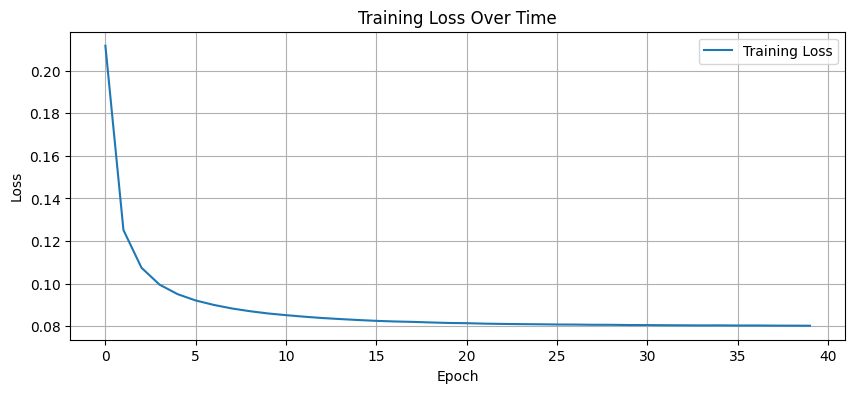

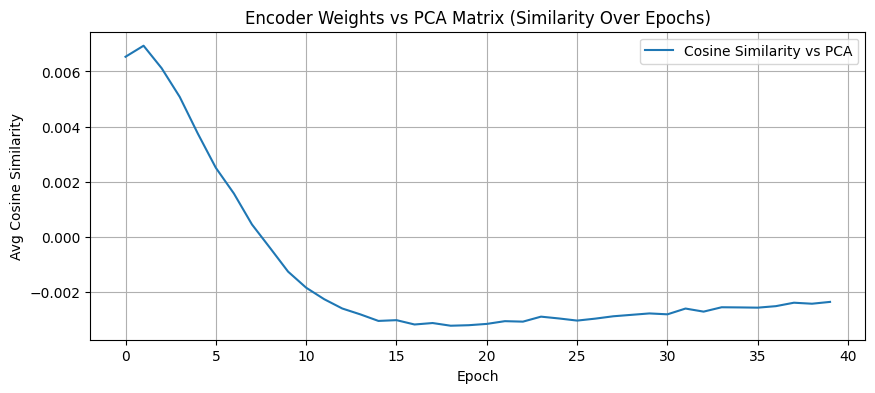

Generating reconstructions...


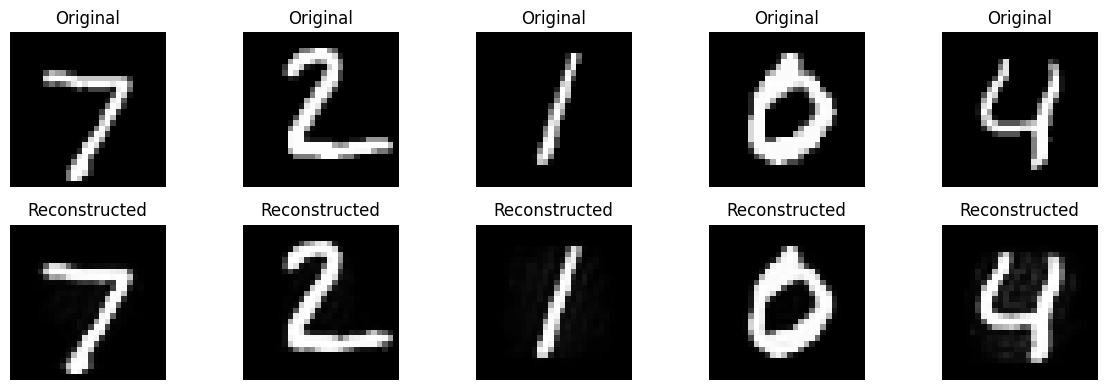

Training completed!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ---------------------------
# 1) Data (MNIST) + Centering
# ---------------------------
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        self.labels = data.iloc[:, 0].values
        self.features = data.iloc[:, 1:].values.astype(np.float32)

        # Scale to [0,1]
        self.features = self.features / 255.0

        # Center the data to have zero mean (per feature)
        self.features = self.features - np.mean(self.features, axis=0)

        # (Optionally) re-scale to [0,1] after centering
        #  The PDF says “center so data have zero mean”. It doesn’t explicitly say
        #  you MUST re-scale to [0,1]. You can keep it or remove it.
        #  Shown here just as in your original code.
        min_vals = np.min(self.features, axis=0)
        max_vals = np.max(self.features, axis=0)
        self.features = (self.features - min_vals) / (max_vals - min_vals + 1e-8)

        # Convert to tensors
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# ----------------------------------
# 2) Compute PCA => Matrix V_L (128)
# ----------------------------------
def compute_pca_matrix(train_dataset, n_components=128):
    # Flatten out the dataset to (N, 784)
    X = train_dataset.features.numpy()  # shape (N, 784)
    pca = PCA(n_components=n_components)
    pca.fit(X)
    # pca.components_ is shape (128, 784) if n_components=128
    return pca.components_

# ---------------------------
# 3) Autoencoder (no biases)
# ---------------------------
class Autoencoder(nn.Module):
    def __init__(self, input_size=784, latent_size=128):
        super(Autoencoder, self).__init__()
        # Fully-connected encoder/decoder, no bias
        self.encoder = nn.Linear(input_size, latent_size, bias=False)
        self.decoder = nn.Linear(latent_size, input_size, bias=False)

        # Xavier initialization
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.xavier_uniform_(self.decoder.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten (batch_size, 784)
        encoded = self.encoder(x)
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded

# ---------------------------------------
# 4) Compare weights with PCA components
# ---------------------------------------
def cosine_similarity(a, b):
    # a, b: 1D vectors
    return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-8)

def compare_weights_with_pca(encoder_weights, VL):
    """
    Compare row-by-row the encoder weights (shape [128, 784])
    with the PCA components (VL, shape [128, 784])
    and return an average similarity measure.
    """
    # encoder_weights => torch.Tensor => shape (128, 784)
    # VL => np.array => shape (128, 784)
    W = encoder_weights.cpu().numpy()
    n_components = W.shape[0]

    similarities = []
    for i in range(n_components):
        sim = cosine_similarity(W[i], VL[i])
        similarities.append(sim)
    return np.mean(similarities)

# ---------------------------------
# 5) Train model & track similarity
# ---------------------------------
def train_model(model, train_loader, VL, num_epochs=40, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)

    criterion = nn.BCELoss()  # Binary cross-entropy
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    similarity_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, _ in train_loader:
            data = data.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, data.view(data.size(0), -1))

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Compute similarity with PCA
        avg_sim = compare_weights_with_pca(model.encoder.weight.data, VL)
        similarity_history.append(avg_sim)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.6f} | AvgCosSim vs PCA: {avg_sim:.4f}")

    # Plot training loss
    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot similarity over epochs
    plt.figure(figsize=(10,4))
    plt.plot(similarity_history, label='Cosine Similarity vs PCA')
    plt.title('Encoder Weights vs PCA Matrix (Similarity Over Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Avg Cosine Similarity')
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images].to(device)
        reconstructions = model(data)

        plt.figure(figsize=(12, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Reconstruction
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# -------------
# 6) Main
# -------------
def main():
    # Hyperparams
    BATCH_SIZE = 250
    LATENT_SIZE = 128
    NUM_EPOCHS = 40

    # Load data
    print("Loading datasets...")
    train_dataset = MNISTDataset('mnist_train.csv')
    test_dataset = MNISTDataset('mnist_test.csv')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Datasets loaded successfully.")


    VL = compute_pca_matrix(train_dataset, n_components=LATENT_SIZE)

    # Initialize AE
    print("Initializing model...")
    model = Autoencoder(input_size=784, latent_size=LATENT_SIZE)

    # Train
    print("Starting training...")
    train_model(model, train_loader, VL, num_epochs=NUM_EPOCHS, learning_rate=0.001)

    # Visualize
    print("Generating reconstructions...")
    visualize_reconstructions(model, test_loader, num_images=5)

    print("Training completed!")

if __name__ == "__main__":
    main()
